# Credit Card Fraud Detection 

# Project Overview 

## Objective
* Predict credit card frauds using a dataset from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

<a id='content'></a>

## Content    
### [Step 1](#step1): Import and explore data 
### [Step 2](#step2): Feature engineering
### [Step 3](#step3): Train-Test data split 
### [Step 4](#step4): Model selection criteria 
### [Step 5](#step5): Apply classification models
   * [Logistic Classification](#log)
   * [Decision Tree Classification](#tree)
   * [Random Forest Classification](#forest)

### [Step 6](#step6): Model selection


-----------
<!-- ### Dealing with imbalanced data
1. Use balanced weight
2. Impose manual penalties 

### Error metics considered in model selection
* Recall - since it's important to correctly identify true positives out of all fraud cases, i.e. minimize false negative which will cost the credit card company further loss.
* Precision - since high false positive rates will likely lead to more operational cost to inspect these suspicious cases, e.g. manual labeling hours to investigate these false positive cases.

### Business decision on the model seelection
While some models may have better recall than others, they typically comes with lower precision rate and possibly higher predicted positive rates, which lead to higher operation costs of manual labor in human labeling stage to investing the claims. 

We will look more closely at cost-benefit comparison from employing each model.


* The dataset is unbalanced with the fraud rate of <1%.
    * The dataset comes with 28 PCA variables and does not need much cleaning or feature engineering.


 -->

<a id='step1'></a>

# Step 1: Import and explore data

* What's the dimension of the dataset?
* What's the fraction of positive cases?

([Back to Content](#content))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math 

data = pd.read_csv("creditcard.csv")

print('Data shape:',data.shape)

data.head(2)

Data shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [2]:
class_freq = pd.DataFrame(data['Class'].value_counts(normalize=True).sort_index()) * 100
print('Distribution of fraud cases in the dataset')

class_freq.style.background_gradient()


Distribution of fraud cases in the dataset


,Class
0,99.827251
1,0.172749


> __Observations__: 
* The percentage of fraud cases is very small, about 0.2%.  
* To tackle this class imbalance issue, we will use balanced weight options and try imposing manual penalties to better predict positive cases. 


In [3]:
# Check for null values, min, max, etc.

def data_overview(df, corr=False, label_name=None, sort_by='qtd_null', thresh_percent_null=0, thresh_corr_label=0):

    df_null = pd.DataFrame(df.isnull().sum()).reset_index()
    df_null.columns = ['feature', 'qtd_null']
    df_null['percent_null'] = df_null['qtd_null'] / len(df)

    df_null['dtype'] = df_null['feature'].apply(lambda x: df[x].dtype)
    df_null['qtd_cat'] = [len(df[col].value_counts()) if df[col].dtype == 'object' else 0 for col in
                          df_null['feature'].values]

    df_null_overview = df_null
    
    df_null_overview['min'] = pd.DataFrame(df.min(), columns=['min']).reset_index().drop(['index'],axis=1)
    df_null_overview['max'] = pd.DataFrame(df.max(), columns=['max']).reset_index().drop(['index'],axis=1)
    df_null_overview['mean'] = pd.DataFrame(df.mean(), columns=['mean']).reset_index().drop(['index'],axis=1)
    df_null_overview['var'] = pd.DataFrame(df.var(), columns=['var']).reset_index().drop(['index'],axis=1)

    df_null_overview.query('percent_null > @thresh_percent_null')

    df_null_overview = df_null_overview.sort_values(by=sort_by, ascending=False)
    df_null_overview = df_null_overview.reset_index(drop=True)

    return df_null_overview



datasets = [data]
names = ['data']
df_overview = pd.DataFrame({})
name_col = []
for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = df_overview.append(data_overview(df))
    df_overview['dataset_name'] = name_col


df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat',
                                  'min','max','mean','var']]
df_overview.sort_values('feature')

,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat,min,max,mean,var
2,data,Amount,0,0.0,float64,0,0.000000,25691.160000,8.834962e+01,6.256007e+04
30,data,Class,0,0.0,int64,0,0.000000,1.000000,1.727486e-03,1.724507e-03
0,data,Time,0,0.0,float64,0,0.000000,172792.000000,9.481386e+04,2.255124e+09
16,data,V1,0,0.0,float64,0,-56.407510,2.454930,3.919560e-15,3.836489e+00
21,data,V10,0,0.0,float64,0,-24.588262,23.745136,1.768627e-15,1.185594e+00
20,data,V11,0,0.0,float64,0,-4.797473,12.018913,9.170318e-16,1.041855e+00
19,data,V12,0,0.0,float64,0,-18.683715,7.848392,-1.810658e-15,9.984034e-01
18,data,V13,0,0.0,float64,0,-5.791881,7.126883,1.693438e-15,9.905708e-01
17,data,V14,0,0.0,float64,0,-19.214325,10.526766,1.479045e-15,9.189055e-01
15,data,V15,0,0.0,float64,0,-4.498945,8.877742,3.482336e-15,8.378034e-01


>__Observations__: 
* V1-V28 all have means around zeros. 
* Most of V1-V28 have variance around 1. 


__Additional data background__:
* The majority of the data contains numerical features, which are the result of a PCA transformation (`V1`, `V2`, … `V28`). 
    * Due to confidentiality issues, no additional information was provided about the features and their meaning. 
    
    
* The only features which have not been transformed with PCA are `Time` and `Amount`. 
    * Feature `Time` contains the seconds elapsed between each transaction and the first transaction in the dataset.
    * The feature `Amount` is the transaction Amount.

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        5.00000e+00, 9.00000e+00, 8.00000e+00, 1.50000e+01, 2.30000e+01,
        2.50000e+01, 4.30000e+01, 1.02000e+02, 2.48000e+02, 1.07700e+03,
        1.71080e+04, 1.71416e+05, 9.46010e+04, 1.25000e+02, 1.00000e+00]),
 array([-48.32558936, -45.44018197, -42.55477458, -39.66936719,
        -36.7839598 , -33.89855241, -31.01314502, -28.12773763,
        -25.24233024, -22.35692285, -19.47151546, -16.58610808,
        -13.70070069, -10.8152933 ,  -7.92988591,  -5.04447852,
         -2.15907113,   0.72633626,   3.61174365,   6.49715104,
          9.38255843]),
 <a list of 20 Patch objects>)

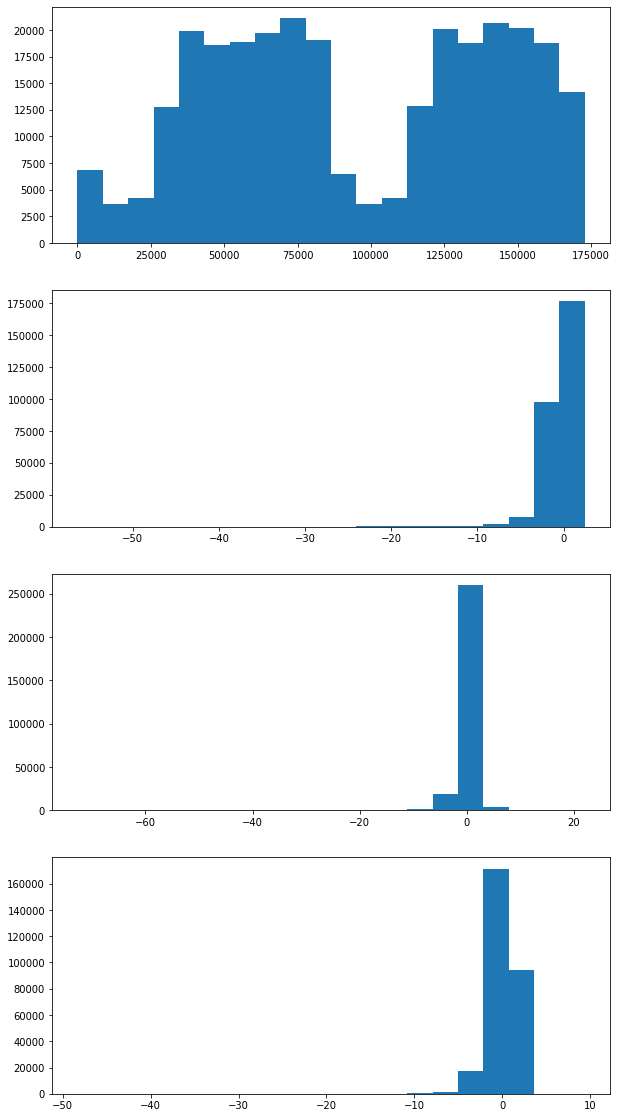

In [4]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)
ax1.hist(data['Time'],bins=20)
ax2.hist(data['V1'],bins=20)
ax3.hist(data['V2'],bins=20)
ax4.hist(data['V3'],bins=20)

>__Observations__:
* The histogram of `Time` variable shows that we have data of transaction within 175,000 seconds from the first transactions, which is about 48 hours. Hence, we can infer that the dataset includes transactions span 48 hours from the first transaction. 
    * Certain time of the day show lower activities   
* The historgram of `V1`-`V3 `shows that the values are centered around zero, as expected


Summary of Amount for fraud cases 
 count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
Summary of Amount for non-fraud cases 
 count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


Text(0.5, 1.0, 'Histogram of Amount for non-fraud cases')

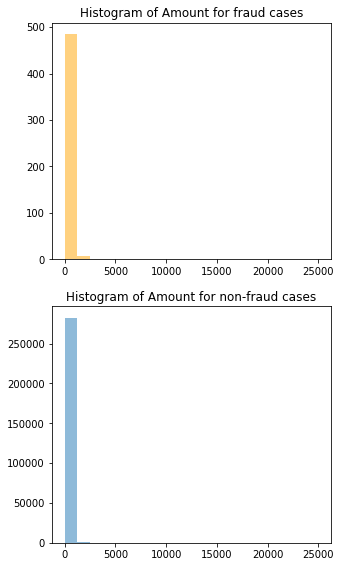

In [5]:
# Is there relationship between value and fraud?

print('Summary of Amount for fraud cases' ,'\n',data[data['Class']==1]['Amount'].describe())
print('Summary of Amount for non-fraud cases','\n', data[data['Class']==0]['Amount'].describe())


fig = plt.figure(figsize=(5,20))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)

ax1.hist(data[data['Class']==1]['Amount'],range=(0,25000),bins=20, alpha=0.5, color = 'orange')
ax1.set_title('Histogram of Amount for fraud cases')
ax2.hist(data[data['Class']==0]['Amount'],range=(0,25000),bins=20, alpha=0.5)
ax2.set_title('Histogram of Amount for non-fraud cases')


>__Observations:__
* While the mean of fraud cases is larger, the distribution of `Amount` in both cases are quite similar.

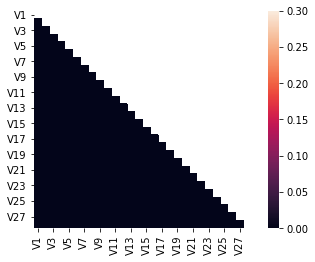

In [6]:
# Correlation among the features: V1-V28

a = [c.startswith('V') for c in data.columns]
components = data.columns[a]

correlation = data[components].corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation, mask=mask, vmax=0.3, square=True)

>__Observations:__
* All of the pairs among `V1`-`V28` are highly uncorrelated, which is due to the fact that these variables were already processed via PCA. 

<a id='step2'></a>

# Step 2: Feature engineering

Typically, we might have to clean and process the dataset before feeding them into the machine learning algorithms, e.g.
* Transform string values into uniform text styles
* Transform numerical information that might have beeen stored as strings into numerical values
* Process string values into dummies or categorical variables 
* Categorize string values into groups if appropriate
* Categorize numerical values into groups if appropriate
* Rescale numerical variabels if appropriate or necessary for certain models 


As for this project, since most variables are already in numerical forms, 
* Rescale `V1`-`V28` and `Amount`
* Transform `Time` variables into hours of the day, and create dummies 

([Back to Content](#content))


In [7]:
# Normalize V1-V28 and Amount

a = [c.startswith('V') for c in data.columns]
Vs = data.columns[a]

data[Vs] = (data[Vs] - data[Vs].mean()) / ( data[Vs].var())**0.5

data['Amount'] = (data['Amount'] - data['Amount'].mean()) / ( data['Amount'].var())**0.5


In [8]:
# Transform Time variables 

data['hour_from_first'] = (data['Time'] / 3600).apply(math.floor)
def mod24(x):
    return math.fmod(x,24)
data['hour_of_day'] = data['hour_from_first'].apply(mod24).astype('int')
print('Hour of the day that transaction occured (assuming Hour 0 for the first transaction)', 
      '\n',
      data['hour_of_day'].value_counts())

hod = pd.get_dummies(data['hour_of_day']).add_prefix('hod')
data = pd.concat([data,hod], axis=1)

Hour of the day that transaction occured (assuming Hour 0 for the first transaction) 
 21    17703
18    17039
11    16856
20    16756
10    16598
14    16570
15    16461
16    16453
17    16166
9     15838
19    15649
22    15441
12    15420
13    15365
23    10938
8     10276
0      7695
7      7243
1      4220
6      4101
3      3492
2      3328
5      2990
4      2209
Name: hour_of_day, dtype: int64


In [9]:
print('Features to be included in the model:', '\n', data.columns)

Features to be included in the model: 
 Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'hour_from_first', 'hour_of_day', 'hod0', 'hod1', 'hod2',
       'hod3', 'hod4', 'hod5', 'hod6', 'hod7', 'hod8', 'hod9', 'hod10',
       'hod11', 'hod12', 'hod13', 'hod14', 'hod15', 'hod16', 'hod17', 'hod18',
       'hod19', 'hod20', 'hod21', 'hod22', 'hod23'],
      dtype='object')


<a id='step3'></a>
# Step 3: Train-Test data split 

This step is important to avoid over-fitting and gives us a better idea how the algorithm will perform with external data. 


([Back to Content](#content))


In [10]:
from sklearn.model_selection import train_test_split

X = data.drop(['Class','Time','hour_of_day','hour_from_first','hour_of_day'],axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=555)


print('Shape of training data', X_train.shape )
print('Shape of testing data', X_test.shape )
print('Features included:','\n', X_train.columns)

Shape of training data (227845, 53)
Shape of testing data (56962, 53)
Features included: 
 Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'hod0',
       'hod1', 'hod2', 'hod3', 'hod4', 'hod5', 'hod6', 'hod7', 'hod8', 'hod9',
       'hod10', 'hod11', 'hod12', 'hod13', 'hod14', 'hod15', 'hod16', 'hod17',
       'hod18', 'hod19', 'hod20', 'hod21', 'hod22', 'hod23'],
      dtype='object')


<a id='step4'></a>
# Step 4: Model selection criteria


## Metrics to consider:
For each model, we will produce the following scores to compare across models:
1. Maximize the accuracy rate 
\begin{align}
Accuracy = \frac{TP +TN}{Total}
\end{align}
2. Maximize the recall  
\begin{align}
Recall = \frac{TP}{TP + FN}
\end{align}
3. Maximize precision rate 
\begin{align}
Precision = \frac{TP}{TP + FP}
\end{align}

Both __recall__ and __precision__ rates are important since 
* We do not want to miss out the true fraud cases (i.e. want to achieve high recall) 
* And we do not want to over-predict the fraud cases (i.e. want to achieve high precision)
* Alternative measure : __F1__ which is a harmonic mean of precision and recall

\begin{align}
F1 = \frac{2TP}{2TP + FP + FN}
\end{align}

 ([Back to Content](#content))


.
<!-- ## Business decision to consider:
We will take a closer look at cost-benefit of employing each model:
* The benefit is defined as the \$ value saved from being able to correctly identify the fradu case:


\begin{align}
\text{Benefit} &= \text{ Recall } * \text{ Total Fraud Value } \\
               &= \text{ Recall } * (\text{ True Fraud Rate } * \text{ Total Cases }  *  \text{ Average \$ Loss per fraud case } )
\end{align}


* The cost is defined as the \$ value of maunal labor in investigating potential fraud cases:


\begin{align}
\text{Cost} &= \text{ Labor Cost per Case } * \text{ Total Potential Fraud Cases } \\
            &= \text{  Average \$ Labor Cost per Case } *  (\text{ Predicted Fraud Rate } * \text{ Total Cases })
\end{align}


* The model with the __largest benefit-cost difference__ should be prioritized.  


\begin{align}
\text{Net Benefit} &= \text{ Total Cases } * &\{ (\text{ Recall } * \text{ True Fraud Rate }   *  \text{ Average \$ Loss per fraud case } \\ & &- (\text{  Average \$ Labor Cost per Case } *  \text{ Predicted Fraud Rate }) \}
\end{align}

Note that:
\begin{align}
\text{ Predicted Fraud Rate }  = \frac{\text{ Recall }}{\text{ Precision } } * \text{ True Fraud Rate } 
\end{align}


Thus, we have:
\begin{align}
\text{Net Benefit} &= (\text{ Total Cases } * \text{ Recall } * \text{ True Fraud Rate }) * \{  \text{Ave \$ Loss per fraud case} -  \frac{\text{ Ave \$ Labor Cost per Case}}{\text{ Precision }} \}
\end{align}


We can see that Net Benefit goes positively with __Recall__  and __Precision__.

 
We will apply a few models below and compute __Net benefit__ -->

<a id='step5'></a>

# Step 5: Apply classification models

The following models are commonly used for classification models and have different pros and cons
   * [Logistic Classification](#log)
   * [Decision Tree Classification](#tree)
   * [Random Forest Classification](#forest)
   
   
([Back to Content](#content))


In [11]:
# Import libraries for classifiaciton models

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import cross_val_score, cross_validate, KFold, \
                                    GridSearchCV, StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix, \
                            mean_squared_error, precision_recall_fscore_support, \
                            make_scorer, precision_score, recall_score, accuracy_score, \
                            f1_score, roc_auc_score



<a id='log'></a>
# Model 1: Logistic Regression

We will look a few variations of regressions:
* Baseline model
* The model with balanced class weight 
* The model with manual penalty weight

([Back to Content](#content))

([Back to Step 5](#step5))


In [12]:
# Logistic model - baseline


def logistic_scores(model,folds):

    scoring = ['accuracy', 'recall', 'precision', 'f1']
    scores = cross_validate(lr, X, y, cv=5, scoring=scoring)
    scores_mean = {}
    for v in ['test_accuracy','test_recall','test_precision','test_f1']:
        scores_mean[v] = round(scores[v].mean()*100,2)
   
    return scores_mean

   

        
lr = LogisticRegression(max_iter=1000)
kf = KFold(5, shuffle=True, random_state=555)

scores_lr = logistic_scores(lr,kf)

 
    
# true_positive_rate = data['Class'].sum() / len(data) * 100
# scores_mean['predicted_positive_rate'] =  round(scores_mean['test_recall']/scores_mean['test_precision'] * true_positive_rate,2)



In [13]:
print('Scores for Logistic model - baseline')
print(scores_lr)

Scores for Logistic model - baseline
{'test_accuracy': 99.91, 'test_recall': 60.74, 'test_precision': 82.78, 'test_f1': 69.31}


In [14]:
# Logistics model - with balanced class weight

lr = LogisticRegression(class_weight="balanced", max_iter=1000)
kf = KFold(5, shuffle=True, random_state=555)

scores_lr_bw = logistic_scores(lr,kf)

 

In [15]:
print('Scores for Logistic model - with balanced class weight')
print(scores_lr_bw)

Scores for Logistic model - with balanced class weight
{'test_accuracy': 96.05, 'test_recall': 88.41, 'test_precision': 4.29, 'test_f1': 8.12}


In [16]:
# Logistics model - with manual penalties 

# This will impose a penalty of 1 for misclassifying a 0, 
# and a penalty of 1 for misclassifying a 10.

penalty = {
    0: 1,
    1: 100
}

lr = LogisticRegression(class_weight=penalty, max_iter=1000)
kf = KFold(5, shuffle=True, random_state=555)

scores_lr_mp = logistic_scores(lr,kf)


In [17]:
print('Scores for Logistic model - with manual penalties')
print(scores_lr_mp)

Scores for Logistic model - with manual penalties
{'test_accuracy': 99.38, 'test_recall': 81.71, 'test_precision': 19.75, 'test_f1': 31.66}


In [18]:
# Scores from multiple Logistic model variations

df_scores_lr = pd.DataFrame(scores_lr, index=['Logistic'])
df_scores_lr_bw = pd.DataFrame(scores_lr_bw, index=['Logistic with balanced weight'])
df_scores_lr_mp = pd.DataFrame(scores_lr_mp, index=['Logistic with manual penalty'])

df_score1 = pd.concat([df_scores_lr, df_scores_lr_bw, df_scores_lr_mp])
df_score1  
    

,test_accuracy,test_recall,test_precision,test_f1
Logistic,99.91,60.74,82.78,69.31
Logistic with balanced weight,96.05,88.41,4.29,8.12
Logistic with manual penalty,99.38,81.71,19.75,31.66


>__Observations__:
* We can see that recall and precision are compromising each other.
    * For example, with balanced weight, we can detect fraud cases better but it comes at the price of false positive. These false positive cases will cause waste in time and resources in investigation.
* For this project, F1-score is most appropriate since we want to maximize both recall and precision.
* Our best model gives F1-score of 69.31%


<!-- Insert summary table for accuracy score, precision and recall.

Right now logistics regression without balanced weight is best.


* With balanced class weight, we sacrifice overall accuracy, from 99.9% to 97.3%, but gain true positive rate (i.e. recall) from 66% to 89%.
* We do worse in false positive rate (up to 2.5% from 0.02%), which may lead to more operation cost. For example, we will need to spend more resources in human labeling and investigating these suspicious cases.



* With manual penalty, we sacrifice overall accuracy as well but not as much as the model with balanced class weight. The accuracy drops less than 0.5%.
* The true positive rate improved to 86%. While this is worse than using balanced weight option, the false positive rate remains low (0.45%). 
 -->

<a id='tree'></a>
# Model 2: Decision Tree

We will apply grid search method to fine-tune some of the model parameters below:

* `max_depth` - Globally restricts how deep the tree can go
* `min_samples_split` - The minimum number of rows a node should have before it can be split; if this is set to 2, for example, then nodes with 2 rows won't be split, and will become leaves instead
* `min_samples_leaf` - The minimum number of rows a leaf must have
* `min_weight_fraction_leaf` - The fraction of input rows a leaf must have
* `max_leaf_nodes` - The maximum number of total leaves; this will cap the count of leaf nodes as the tree is being built

Some of these parameters are not compatible. For example, `max_leaf_nodes` and `max_depth`


([Back to Content](#content))

([Back to Step 5](#step5))


In [19]:
# Grid search with the scoring argument (Optimize for F1 score)

np.random.seed(555)

tree = DecisionTreeClassifier()
    
param_grid = {
    'min_samples_split': [10, 20],
    'max_depth': [10, 20],
    'max_features': [10, 20]
}



scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}


skf = StratifiedKFold(n_splits=2)

refit_score = 'f1_score'

grid_search_tree = GridSearchCV(tree, param_grid, 
                           scoring=scorers, 
                           refit=refit_score,
                           cv=skf, 
                           return_train_score=True)

grid_search_tree.fit(X_train, y_train)
y_pred = grid_search_tree.predict(X_test)
 



In [20]:
print('Best params for {}'.format(refit_score))

print(grid_search_tree.best_params_)

Best params for f1_score
{'max_depth': 10, 'max_features': 20, 'min_samples_split': 10}


In [21]:
model = 'Decision Tree'

df_cv_results = pd.DataFrame(grid_search_tree.cv_results_)

df_cv_results2 = df_cv_results[['param_max_depth','param_max_features','param_min_samples_split',
                                'mean_test_accuracy_score','mean_test_recall_score',
                                'mean_test_precision_score','mean_test_f1_score',
                                'rank_test_f1_score']]

df_cv_results3 = df_cv_results[df_cv_results['rank_test_f1_score']==1][['mean_test_accuracy_score','mean_test_recall_score',
                                'mean_test_precision_score','mean_test_f1_score']]

df_cv_results3 = df_cv_results3.rename({'mean_test_accuracy_score':'test_accuracy',
                                        'mean_test_recall_score':'test_recall',
                                        'mean_test_precision_score':'test_precision',
                                        'mean_test_f1_score':'test_f1'}, axis='columns')
df_cv_results3 = df_cv_results3.reset_index(drop=True)
df_cv_results3 = df_cv_results3.rename({0:'Decision Tree'}, axis='index')
df_cv_results3 = round(df_cv_results3*100,2)
print('Scoring for best {}'.format(model))

print(df_cv_results3)

Scoring for best Decision Tree
               test_accuracy  test_recall  test_precision  test_f1
Decision Tree          99.93        71.69           86.44    78.17


In [22]:
df_score2 = pd.concat([df_score1,df_cv_results3])

df_score2 

,test_accuracy,test_recall,test_precision,test_f1
Logistic,99.91,60.74,82.78,69.31
Logistic with balanced weight,96.05,88.41,4.29,8.12
Logistic with manual penalty,99.38,81.71,19.75,31.66
Decision Tree,99.93,71.69,86.44,78.17


__Observations:__

* Decision Tree models (F1-score of 78.17%) perform better than Logistic model (F1-score of 69.31%)



<a id='forest'></a>
# Model 3: Random Forest

Decision tree tend to be subjected to overfitting issue. Random forrests is an ensemble of trees and ususally have less overfitting issue. 


([Back to Content](#content))

([Back to Step 5](#step5))


In [23]:
np.random.seed(555)

forest = RandomForestClassifier()

param_grid = {
    'min_samples_split': [5, 10, 20],
    'max_depth': [10, 20, 30],
    'max_features': [10, 20, 30],
    'n_estimators': [30, 50,100]
}



scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}


skf = StratifiedKFold(n_splits=2)

refit_score = 'f1_score'

grid_search = GridSearchCV(forest, param_grid, 
                           scoring=scorers, 
                           refit=refit_score,
                           cv=skf, 
                           return_train_score=True)

grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
 



In [24]:
print('Best params for {}'.format(refit_score))

print(grid_search.best_params_)

Best params for f1_score
{'max_depth': 30, 'max_features': 20, 'min_samples_split': 5, 'n_estimators': 30}


In [25]:
model = 'Random Forest'



df_cv_results = pd.DataFrame(grid_search.cv_results_)

df_cv_results2 = df_cv_results[['param_max_depth','param_max_features','param_min_samples_split',
                                'mean_test_accuracy_score','mean_test_recall_score',
                                'mean_test_precision_score','mean_test_f1_score',
                                'rank_test_f1_score']]

df_cv_results3 = df_cv_results[df_cv_results['rank_test_f1_score']==1][['mean_test_accuracy_score','mean_test_recall_score',
                                'mean_test_precision_score','mean_test_f1_score']]

df_cv_results3 = df_cv_results3.rename({'mean_test_accuracy_score':'test_accuracy',
                                        'mean_test_recall_score':'test_recall',
                                        'mean_test_precision_score':'test_precision',
                                        'mean_test_f1_score':'test_f1'}, axis='columns')
df_cv_results3 = df_cv_results3.reset_index(drop=True)
df_cv_results3 = df_cv_results3.rename({0:model}, axis='index')
df_cv_results3 = round(df_cv_results3*100,2)


print('Scoring for best {}'.format(model))

print(df_cv_results3)

Scoring for best Random Forest
               test_accuracy  test_recall  test_precision  test_f1
Random Forest          99.95         77.2            92.4    83.99


In [26]:
df_score3 = pd.concat([df_score2,df_cv_results3])

df_score3

,test_accuracy,test_recall,test_precision,test_f1
Logistic,99.91,60.74,82.78,69.31
Logistic with balanced weight,96.05,88.41,4.29,8.12
Logistic with manual penalty,99.38,81.71,19.75,31.66
Decision Tree,99.93,71.69,86.44,78.17
Random Forest,99.95,77.20,92.40,83.99


__Observations:__

* Random Forest model (best model has F1-score of 83.99%) perform better than Decision Tree model (best score of 78.17%) and Logistic model (F1-score of 69.31%).



<a id='step6'></a>

# Step 6: Model Selection

Based on F1-scores, we are choosing the Random Forest model with the following specifics:
* `max_depth`: 30
* `max_feature` : 20
* `min_samples_split`: 5
* `n_estimators`: 30



# Summary

While this model gives the highest average of the precision and recall rates, 
* It takes longer time to process 
* And is harder to understand the influence of each features on the outcome,  

compared to Logistic Regression and Decision Tree. 